In [1]:
#!pip install nltk

#nltk.download('stopwords');

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
import nltk
import time
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import matplotlib.pyplot as plt
import collections
from numpy import linalg as la
import pandas as pd
import re

Load tweets from local: for now we use the lab1 loading for reference

In [4]:
# Load data
csv_file_data = 'Data/Output_v5_data_anonim.csv'
data_raw = pd.read_csv(csv_file_data, quotechar='"',low_memory=False)
#print(data_raw)

csv_file_hashtag = 'Data/Output_v5_hash_anonim.csv'
hashtags_raw =pd.read_csv(csv_file_hashtag, quotechar='"',low_memory=False)
#print(hashtags_raw)

In [5]:
data_raw.head()

,tweet_id,text,user_screen_name,created_at,favorite_count,retweet_count,user_followers,url,user_followers_index
0,1,The polls are absolutely wrong! All you have t...,590ecf4c5b88c57f5658f3097f32efd2,Tue Oct 20 15:11:08 +0000 2020,0,0,3,https://twitter.com/twitter/statuses/131857045...,0.832457
1,8,_Lai And the dangerous part? When there is pu...,203afe8023cab3bb1fa15ec48c737a71,Tue Oct 20 15:10:48 +0000 2020,18,1,2502,https://twitter.com/twitter/statuses/131857037...,0.915293
2,19,News flash. tRump IS a politician. https://t.c...,a708a5aef0063b7a40cd2bbbf51984c0,Tue Oct 20 15:10:10 +0000 2020,1,0,275,https://twitter.com/twitter/statuses/131857020...,0.845215
3,35,#NewYorkPost published a report saying e-mails...,c1170c45d30c5a1c258ba52e5e8349f6,Tue Oct 20 15:09:31 +0000 2020,1,1,106,https://twitter.com/twitter/statuses/131857004...,0.837466
4,39,@realDonaldTrump @JoeBiden GOP HAS APPOINT...,2d9df2e6b9ecba9c119fc674c211b5ec,Tue Oct 20 15:09:14 +0000 2020,0,0,197,https://twitter.com/twitter/statuses/131856997...,0.841707


In [6]:
hashtags_raw.head()

,tweet_id,hastags
0,35,NewYorkPost
1,35,JoeBiden
2,35,HunterBiden
3,35,BREAKING
4,35,Hunterbidenlaptop


In [7]:
hashtags_raw = hashtags_raw.groupby(['tweet_id'])['hastags'].apply(', '.join).reset_index()

data = data_raw.merge(hashtags_raw, on='tweet_id',how='left')

data = data.sort_values(by=['tweet_id'])

data.rename(columns={'hastags':'hashtags'},inplace=True)

data.head()

#for trying
data = data[:15000]

#hashtags_raw.head()

In [8]:
data.iloc[21]

tweet_id                                                              272
text                     I'm pretty happy to hear that #8 supports the...
user_screen_name                         998be0e4bcfebf7245ac684c4e6037df
created_at                                 Tue Oct 20 14:54:10 +0000 2020
favorite_count                                                          0
retweet_count                                                           0
user_followers                                                        175
url                     https://twitter.com/twitter/statuses/131856618...
user_followers_index                                             0.840697
hashtags                                                              NaN
Name: 21, dtype: object

Functions:
    - getTerms(line)  --> extract tweet items
    - create_index(lines) --> get dictionaries
    - search(query, index) --> busca docs que contienen todos los elementos de la query

En cuanto tengamos la estructura de los tweets tendremos que modificar getTerms (getTerms(tweets)) y create_index (create_index(tweets)) para que se adapten a la estructura y construyan los diccionarios con lo que queremos.

# Index functions

In [9]:
def getTerms():
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
    global data
    data['words'] = data['text'].str.lower()

    # Special characters removal (mentions, URLs, punctuation and rt)
    data['words'] = data['words'].apply(lambda x: re.sub(r"([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))  
    data['words'] = data['words'].str.split()
    # Stopwords removal
    stop = set(stopwords.words("english"))
    data['words'] = data['words'].apply(lambda x:([y for y in x if y not in stop]))
    # Stemming
    stemming = PorterStemmer()
    data['words'] = data['words'].apply(lambda x: ([stemming.stem(word) for word in x]))


In [10]:
getTerms()

In [11]:
def getTerms_str(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
        
    stemming = PorterStemmer()
    stops = set(stopwords.words("english"))
    ## START CODE
    line = line.lower() ## Transform in lowercase
    line = re.sub(r"([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", line)
    line = line.split() ## Tokenize the text to get a list of terms
    line = [term for term in line if term not in stops]  ##eliminate the stopwords (HINT: use List Comprehension)
    line =[stemming.stem(term) for term in line] ## perform stemming (HINT: use List Comprehension)
    ## END CODE
    return line


In [12]:
def create_index_tfidf():
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of Wikipedia articles
    numDocuments -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """
    global data

    numDocuments=len(data.index)
    
    index=defaultdict(list)
    tf=defaultdict(list) #term frequencies of terms in documents (documents in the same order as in the main index)
    df=defaultdict(int)         #document frequencies of terms in the corpus
    idf=defaultdict(float)

    for num, row in data.iterrows():

        page_id = row['tweet_id']       
        terms = row['words'] #page_title + page_text
       
        
        ## ===============================================================        
        ## create the index for the **current page** and store it in termdictPage
        ## termdictPage ==> { ‘term1’: [currentdoc, [list of positions]], ...,‘termn’: [currentdoc, [list of positions]]}
        
        ## Example: if the curr_doc has id 1 and his text is 
        ## "web retrieval information retrieval":
        
        ## termdictPage ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}
        
        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        termdictPage={}

        for position, term in enumerate(terms): ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corrisponding list
                termdictPage[term][page_id].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in python)
        
        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm=0
        for term, posting in termdictPage.items(): 
            # posting is a list containing doc_id and the list of positions for current term in current document: 
            # posting ==> [currentdoc, [list of positions]] 
            # you can use it to inferr the frequency of current term.
            norm+=len(posting[1])**2
        norm=math.sqrt(norm)


        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():     
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4))  ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term]= df[term] + 1  # increment df for current term
        
        #merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
            
    # Compute idf following the formula (3) above. HINT: use np.log
    for term in df:
        idf[term] = np.round(np.log(float(len(termdictPage.items())/df[term])),4)

    return index, tf, df, idf


In [13]:
def rankDocuments(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    titleIndex -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """
    global data
    
    T=1
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector=[0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for queryVector
    
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex]= query_terms_count[term]/query_norm * idf[term]

        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            # Example of [docIndex, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....
            
            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term]  # TODO: check if multiply for idf
                if(T==1):
                    print(docVectors[doc][termIndex],doc,termIndex)
                    T=0
    # calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine siilarity
    # see np.dot
    method = input('Select Method:\n\t-Standard\n\t-Custom\n')
    if method=='Custom':
        print('Custom Method')
        #Our own score function
        for doc, curDocVec in docVectors.items():
            print(data.loc[doc,'user_followers_index'], doc)
        docScores=[ [data.loc[doc,'user_followers_index']*np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    else:
        print('Standard Method')
        #The  TF-IDF + cosine similarity scoring
        docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    #print document titles instead if document id's
    
    if len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)    
    #print ('\n'.join(resultDocs), '\n')
    return docScores

In [14]:
def search_tf_idf(query, index):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=getTerms_str(query)
    
    init_docs = [posting[0] for posting in index[query[0]]]
    docs = set(init_docs)
    
    for term in query[1:]:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs = docs.intersection(set(termDocs))
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf)   
    return ranked_docs

In [15]:
def print_tweet(tweet, n, score):
    '''
    Print information about tweet n from the ranking in a organized format.
    
    Argument:
    tweet -- information to print
    n -- number of tweet in the ranking
    '''
    print('\nResult {} (score {:.5})'.format(n,score))
    print("-"*70)
    print(tweet.text)
    if isinstance(tweet.hashtags,str):
        print(f'\nHashtags: {tweet.hashtags}')
    print(f'\nTweet by user {tweet.user_screen_name}')
    print(f'\t❤️ {tweet.favorite_count}\t🔁 {tweet.retweet_count}\t📅{tweet.created_at}')
    print(f'Url: {tweet.url}\n')
    print("="*70)

In [16]:
from IPython.display import display
def search_engine(data, index, tsv=False):
    query = input("Search: ")
    result = search_tf_idf(query, index)
    
    #first score, next id
    scoresx= [x[0] for x in result]
    positionx= [x[1] for x in result]
    tweets = data[data['tweet_id'].isin(positionx)].set_index('tweet_id')
    
    to_return = pd.DataFrame()
    vars_to_return = ['text','user_screen_name','created_at','hashtags','favorite_count','retweet_count','url']
    
    print("="*70)
    for i in range(0,min(20,len(tweets)),1):
        tweet = tweets.loc[positionx[i]]
        print_tweet(tweet, i+1, scoresx[i])
        if tsv == True:
            to_append = tweet.loc[vars_to_return]
            to_return = to_return.append(to_append,ignore_index=True)
    
    if tsv == True:
        name = str('ranking_'+query+'_basic.tsv')
        to_return.to_csv(name, sep = '\t', quotechar='"')

In [17]:
index, tf, df, idf = create_index_tfidf()

# Research Questions

# 1stRQ - Output Analysis


In [22]:
data.head()

,tweet_id,text,user_screen_name,created_at,favorite_count,retweet_count,user_followers,url,user_followers_index,hashtags,words
0,1,The polls are absolutely wrong! All you have t...,590ecf4c5b88c57f5658f3097f32efd2,Tue Oct 20 15:11:08 +0000 2020,0,0,3,https://twitter.com/twitter/statuses/131857045...,0.832457,NaN,"[poll, absolut, wrong, watch, ralli, see, incr..."
1,8,_Lai And the dangerous part? When there is pu...,203afe8023cab3bb1fa15ec48c737a71,Tue Oct 20 15:10:48 +0000 2020,18,1,2502,https://twitter.com/twitter/statuses/131857037...,0.915293,NaN,"[lai, danger, part, pushback, dont, say, anyth..."
2,19,News flash. tRump IS a politician. https://t.c...,a708a5aef0063b7a40cd2bbbf51984c0,Tue Oct 20 15:10:10 +0000 2020,1,0,275,https://twitter.com/twitter/statuses/131857020...,0.845215,NaN,"[news, flash, trump, politician]"
3,35,#NewYorkPost published a report saying e-mails...,c1170c45d30c5a1c258ba52e5e8349f6,Tue Oct 20 15:09:31 +0000 2020,1,1,106,https://twitter.com/twitter/statuses/131857004...,0.837466,"NewYorkPost, JoeBiden, HunterBiden, BREAKING, ...","[newyorkpost, publish, report, say, email, obt..."
4,39,@realDonaldTrump @JoeBiden GOP HAS APPOINT...,2d9df2e6b9ecba9c119fc674c211b5ec,Tue Oct 20 15:09:14 +0000 2020,0,0,197,https://twitter.com/twitter/statuses/131856997...,0.841707,NaN,"[realdonaldtrump, joebiden, gop, appoint, 14, ..."


In [23]:
data.shape

(15000, 11)

In [24]:
data[data['tweet_id']==1].words.to_list()[0]

['poll',
 'absolut',
 'wrong',
 'watch',
 'ralli',
 'see',
 'incred',
 'amount',
 'peopl',
 'attend',
 'look',
 'like',
 'ralli',
 'keep',
 'get',
 'bigger',
 'amp',
 'bigger',
 'vote',
 'trump']

In [25]:
#!pip install gensim

## Words embedding work

With the next cells we transform each given word in our tweets to a vector representation in 300 dimensions.

In [26]:
import gensim.models


words_per_tweet = data.words.to_list()
training_words = [item for sublist in words_per_tweet for item in sublist]

# min_count = 1, doing so all words are vectorized

model = gensim.models.Word2Vec(words_per_tweet,min_count=1,size=300)
#model.build_vocab(training_words)
#model.train(training_words,total_examples=len(training_words),epochs=30)

In [27]:
# see some arithmetics
model[training_words[0]] + model[training_words[1]] + np.zeros(300) 

array([-0.33790234, -0.20018166, -0.49553519, -0.10608661, -0.51023394,
       -0.28475729, -1.25093782, -0.84848356,  0.56226552,  0.35766244,
        0.32776934, -0.07128845,  0.52178776,  1.04163253, -0.24980499,
        0.66270232,  0.33730471, -0.07023871,  0.77313125,  0.1772536 ,
        0.96871775, -0.32951969,  0.26000896, -0.19666159, -0.05398265,
       -0.54829228, -0.61394775,  0.01401063, -0.10984644, -0.28021854,
        0.12380865, -0.19750196,  0.66720164, -0.16564399, -0.09558515,
        0.26276356,  0.382388  ,  0.36379632,  0.80350798, -0.56610006,
        0.08061344,  0.04831944,  0.45147339, -0.0285003 , -0.02178315,
        0.09855216,  0.07738285,  0.33854127, -0.19382194, -0.4000572 ,
        0.07420944,  0.44697005, -0.20029111,  0.60244572,  0.262043  ,
       -0.92989171, -0.27319783,  0.63695735, -0.19485545, -0.35012767,
        0.81105459,  0.15047176,  0.18859048, -0.21646312, -0.80230987,
        0.6103375 ,  0.06752306, -0.80461812,  0.12156982, -0.54

In [28]:
vocabulary = model.wv.vocab.keys()
training_words[0] in vocabulary

True

The next cell should not print nothing at all, because it means that all possible words are in the embedding space.

In [29]:
for word in training_words:
    if word not in vocabulary:
        print(word)
   

# Searching and ranking in word2vec + cosine similarity implementation

As says in project 1stRQ requirements, we compute sentences as averaged combinations of word vectors in the embedded space. So, query and tweet messages are first computed as averaged combinations of their own words in the N dimensional space (300), and then similarity score between query and document is computed as the cosine similarity, i.e the dot product of both normalized vectors.

In [30]:
def word2vec_ranking(model,query,tweet_id_list,data):
    
    from numpy import linalg as LA
    import numpy as np
    
    # computes cosine similarities from embedded word vectors
    
    cosine_dict = {} # query-doc similarity
    ranked_tweets = []
    
    # query average embedding
    u = np.zeros(300)
    for i in range(len(query)):
        u = u + model[query[i]]
    u = u*(1/len(query))
    
    for tweet_id in tweet_id_list:
        
        tweet_words = data[data['tweet_id']==tweet_id].words.to_list()[0]
        
        # tweet text average embedding
        v = np.zeros(300)
        for i in range(len(tweet_words)):
            v = v + model[tweet_words[i]]
        v = v*(1/len(tweet_words))
    
        cosine_dict[tweet_id] = np.dot(u,v)/(LA.norm(u)*LA.norm(v))
    
    sorted_similarities=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order
    
    for item in sorted_similarities:
        ranked_tweets.append(list([item[0],item[1]]))
    
    # returns tweet ids
    return ranked_tweets

In [31]:
def search_word2vec(query, index, model, data):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=getTerms_str(query)
    
    init_docs = [posting[0] for posting in index[query[0]]]
    docs = set(init_docs)
    
    for term in query[1:]:
        try:
                                  
            termDocs=[posting[0] for posting in index[term]]
            
            docs = docs.intersection(set(termDocs))
        except:
            #term is not in index
            pass
        
   
    docs=list(docs) # lista de tweet ids
    
    ranked_docs = word2vec_ranking(model,query,docs,data)
    return ranked_docs

In [32]:
def search_engine_word2vec(model, data, index, tsv=False):
    query = input("Search: ")
    result = search_word2vec(query, index, model, data)
    positionx= [x[0] for x in result]
    scoresx= [x[1] for x in result]
    tweets = data[data['tweet_id'].isin(positionx)].set_index('tweet_id')
    
    to_return = pd.DataFrame()
    vars_to_return = ['text','user_screen_name','created_at','hashtags','favorite_count','retweet_count','url']
    
    print("="*70)
    for i in range(0,min(20,len(tweets)),1):
        tweet = tweets.loc[positionx[i]]
        print_tweet(tweet, i+1, scoresx[i])
        
        if tsv == True:
            to_append = tweet.loc[vars_to_return]
            to_return = to_return.append(to_append,ignore_index=True)
    
    if tsv == True:
        name = str('ranking_'+query+'_word2vec.tsv')
        to_return.to_csv(name, sep = '\t', quotechar='"')

In [33]:
search_engine_word2vec(model, data, index, tsv=True)

Search: biden idiot

Result 1 (score 0.99661)
----------------------------------------------------------------------
 @realDonaldTrump Biden is the perfect idiot

Tweet by user d7eafeb9d00de4f60930adb0f6b74366
	❤️ 0	🔁 0	📅Thu Oct 15 02:45:24 +0000 2020
Url: https://twitter.com/twitter/statuses/1316570842235629571


Result 2 (score 0.99254)
----------------------------------------------------------------------
If Joe Biden is weak on China imagine how weak the idiot currently acting as #POTUS with Chinese bank accounts is? https://t.co/quQ1ttYe1S

Hashtags: POTUS

Tweet by user 1ca67c9e77515179717a750b585d9dd3
	❤️ 0	🔁 0	📅Wed Oct 21 01:10:05 +0000 2020
Url: https://twitter.com/twitter/statuses/1318721183198662657


Result 3 (score 0.99009)
----------------------------------------------------------------------
  Ly’in Biden’s. Bring this up at your next Town Hall. Oh! That’s right. “We don’t need to know the truth”. You said that sir not me. Idiots!

Tweet by user 4cb35fdc326737aee621a8668

## Tweets embedding, projection and clustering

In [34]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np 

In [35]:
def get_vectors(data,model):
    
    vectors = []
    
    tweet_ids = data.tweet_id.values

    for num, row in data.iterrows():

        tweet_words = row.words
        
        
    
        if len(tweet_words)!=0:

            v = np.zeros(300)
            for i in range(len(tweet_words)):
                v = v + model[tweet_words[i]]
            v = v*(1/len(tweet_words))

            vectors.append(v)

    vectors = np.asarray(vectors)
    return vectors
    

In [36]:
tweet_vecs = get_vectors(data,model)
tweet_vecs

array([[-0.17936488, -0.07315646, -0.27115755, ..., -0.49759288,
        -0.47030676, -0.27583759],
       [-0.12846426, -0.06387355, -0.20143383, ..., -0.4154092 ,
        -0.40009838, -0.22899265],
       [-0.15665851, -0.04667729, -0.23722133, ..., -0.42573919,
        -0.36162015, -0.24506878],
       ...,
       [-0.14882417, -0.11147638, -0.210041  , ..., -0.45869077,
        -0.43195116, -0.23810062],
       [-0.19103662, -0.04036144, -0.29847356, ..., -0.41382197,
        -0.37734608, -0.25127787],
       [-0.19586956, -0.0373977 , -0.29738899, ..., -0.4621081 ,
        -0.34781688, -0.27521312]])

In [37]:
aux = list(data.words)
word_count = []

for i in data.index:
    word_count.append(len(aux[i]))
    
data['word_count'] = word_count

In [38]:
data.head()

,tweet_id,text,user_screen_name,created_at,favorite_count,retweet_count,user_followers,url,user_followers_index,hashtags,words,word_count
0,1,The polls are absolutely wrong! All you have t...,590ecf4c5b88c57f5658f3097f32efd2,Tue Oct 20 15:11:08 +0000 2020,0,0,3,https://twitter.com/twitter/statuses/131857045...,0.832457,NaN,"[poll, absolut, wrong, watch, ralli, see, incr...",20
1,8,_Lai And the dangerous part? When there is pu...,203afe8023cab3bb1fa15ec48c737a71,Tue Oct 20 15:10:48 +0000 2020,18,1,2502,https://twitter.com/twitter/statuses/131857037...,0.915293,NaN,"[lai, danger, part, pushback, dont, say, anyth...",18
2,19,News flash. tRump IS a politician. https://t.c...,a708a5aef0063b7a40cd2bbbf51984c0,Tue Oct 20 15:10:10 +0000 2020,1,0,275,https://twitter.com/twitter/statuses/131857020...,0.845215,NaN,"[news, flash, trump, politician]",4
3,35,#NewYorkPost published a report saying e-mails...,c1170c45d30c5a1c258ba52e5e8349f6,Tue Oct 20 15:09:31 +0000 2020,1,1,106,https://twitter.com/twitter/statuses/131857004...,0.837466,"NewYorkPost, JoeBiden, HunterBiden, BREAKING, ...","[newyorkpost, publish, report, say, email, obt...",14
4,39,@realDonaldTrump @JoeBiden GOP HAS APPOINT...,2d9df2e6b9ecba9c119fc674c211b5ec,Tue Oct 20 15:09:14 +0000 2020,0,0,197,https://twitter.com/twitter/statuses/131856997...,0.841707,NaN,"[realdonaldtrump, joebiden, gop, appoint, 14, ...",21


In [39]:
data.shape

(15000, 12)

In [40]:
tweets_data = data[data['word_count']!=0]

In [41]:
tweets_data.shape[0]

14917

Up to here we have embedded tweets in tweets_data dataframe

In [42]:
tweets_data.shape[0] == len(tweet_vecs)

True

Assign vector representation to each tweet

In [43]:
tweets_data['tweet_vector'] = list(tweet_vecs)

tweets_data.head()

<ipython-input-43-f630f1795951>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_data['tweet_vector'] = list(tweet_vecs)


,tweet_id,text,user_screen_name,created_at,favorite_count,retweet_count,user_followers,url,user_followers_index,hashtags,words,word_count,tweet_vector
0,1,The polls are absolutely wrong! All you have t...,590ecf4c5b88c57f5658f3097f32efd2,Tue Oct 20 15:11:08 +0000 2020,0,0,3,https://twitter.com/twitter/statuses/131857045...,0.832457,NaN,"[poll, absolut, wrong, watch, ralli, see, incr...",20,"[-0.17936488296836617, -0.07315646121278406, -..."
1,8,_Lai And the dangerous part? When there is pu...,203afe8023cab3bb1fa15ec48c737a71,Tue Oct 20 15:10:48 +0000 2020,18,1,2502,https://twitter.com/twitter/statuses/131857037...,0.915293,NaN,"[lai, danger, part, pushback, dont, say, anyth...",18,"[-0.12846425771325204, -0.0638735496419637, -0..."
2,19,News flash. tRump IS a politician. https://t.c...,a708a5aef0063b7a40cd2bbbf51984c0,Tue Oct 20 15:10:10 +0000 2020,1,0,275,https://twitter.com/twitter/statuses/131857020...,0.845215,NaN,"[news, flash, trump, politician]",4,"[-0.15665851207450032, -0.0466772944200784, -0..."
3,35,#NewYorkPost published a report saying e-mails...,c1170c45d30c5a1c258ba52e5e8349f6,Tue Oct 20 15:09:31 +0000 2020,1,1,106,https://twitter.com/twitter/statuses/131857004...,0.837466,"NewYorkPost, JoeBiden, HunterBiden, BREAKING, ...","[newyorkpost, publish, report, say, email, obt...",14,"[-0.13734367080698054, -0.06687563132644364, -..."
4,39,@realDonaldTrump @JoeBiden GOP HAS APPOINT...,2d9df2e6b9ecba9c119fc674c211b5ec,Tue Oct 20 15:09:14 +0000 2020,0,0,197,https://twitter.com/twitter/statuses/131856997...,0.841707,NaN,"[realdonaldtrump, joebiden, gop, appoint, 14, ...",21,"[-0.1259652637166991, -0.062298461151797144, -..."


Now we check that vectors are correctly assigned

In [44]:
from numpy import linalg as LA
import numpy as np
num_tweet_vecs = len(tweet_vecs)
for i in range(num_tweet_vecs):
    if (LA.norm(tweet_vecs[i]) != LA.norm(tweets_data.iloc[i,12])):
        print(i)

### Dimensionality reduction using TSNE and plot
We will use a sample made of the 100000 first tweet vectors

In [45]:
import time

def reduce_dimensions(vecs):

    # reduce usint t-SNE
    tsne = TSNE(n_components=2, random_state=0,n_jobs=-1)
    vectors = tsne.fit_transform(vecs)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals


In [46]:
tweet_vecs_sample = tweet_vecs[:100000]
start = time.time()

x_vals, y_vals = reduce_dimensions(tweet_vecs_sample)

time.time() - start

67.2367684841156

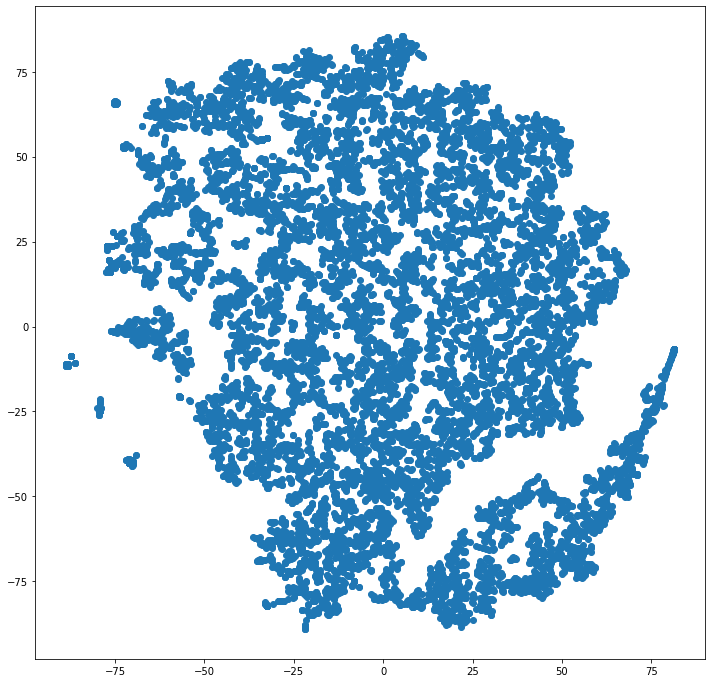

In [47]:
def plot_with_matplotlib(x_vals, y_vals):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)



plot_with_matplotlib(x_vals,y_vals)

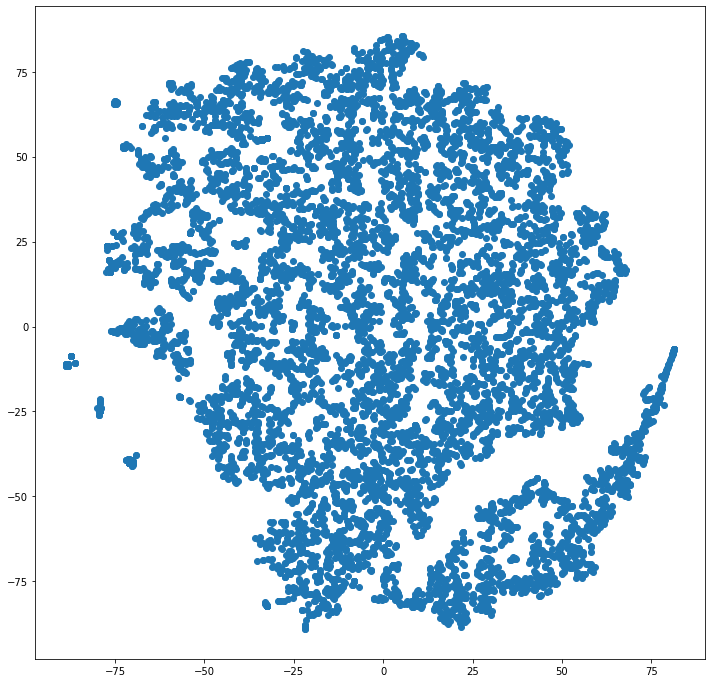

In [48]:
plot_with_matplotlib(x_vals[:10000],y_vals[:10000])

In [49]:
tweets_2d = []

for i in range(len(x_vals)):
    aux = [x_vals[i],y_vals[i]]
    tweets_2d.append(aux)

In [50]:
tweets_2d = np.asarray(tweets_2d) 

In [51]:
len(tweets_2d)

14917

In [52]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 

In [53]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,15) 
X = tweets_2d  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


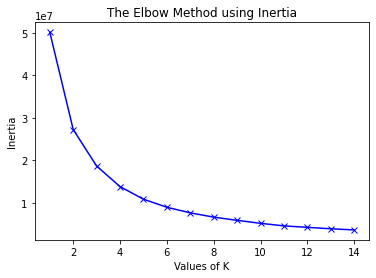

In [54]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


Elbow method is a common used estimate to obtain the optimal number of clusters. The criteria behind is to pick the integer after which the distortion/inertia plot start decreasing linearly. In our case we will pick 6 clusters.

In [55]:
from sklearn.cluster import KMeans
X = tweets_2d 
km = KMeans(n_clusters=6)
y = km.fit_predict(X)



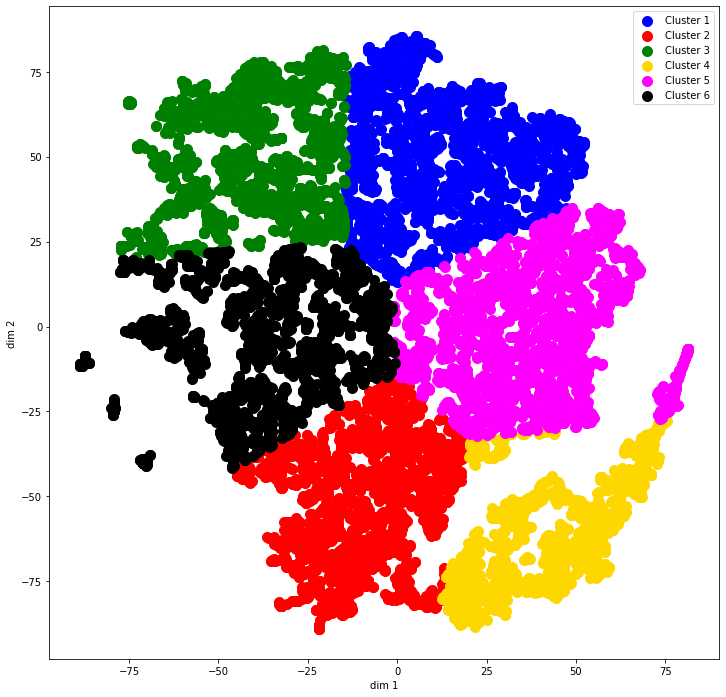

In [56]:
plt.figure(figsize=(12, 12))

plt.scatter(X[y==0, 0], X[y==0, 1], s=100, c='blue', label = 'Cluster 1')
plt.scatter(X[y==1, 0], X[y==1, 1], s=100, c='red', label = 'Cluster 2')
plt.scatter(X[y==2, 0], X[y==2, 1], s=100, c='green', label = 'Cluster 3')
plt.scatter(X[y==3, 0], X[y==3, 1], s=100, c='gold', label = 'Cluster 4')
plt.scatter(X[y==4, 0], X[y==4, 1], s=100, c='magenta', label = 'Cluster 5')
plt.scatter(X[y==5, 0], X[y==5, 1], s=100, c='black', label = 'Cluster 6')



plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.legend()
plt.show()

In [57]:
cluster_target = y
len(cluster_target)

14917

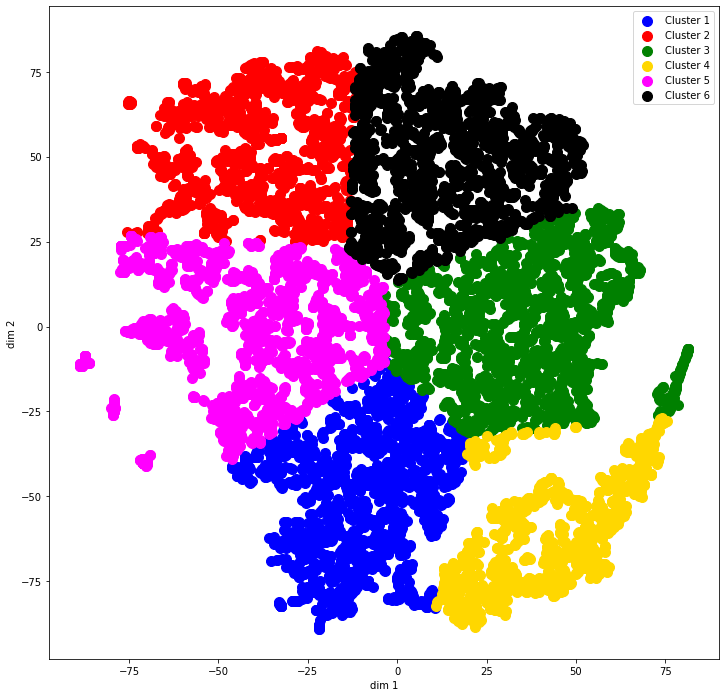

In [58]:
from sklearn.cluster import KMeans

X = X[0:10000]

km = KMeans(n_clusters=6,random_state=0)
y = km.fit_predict(X)

plt.figure(figsize=(12, 12))

plt.scatter(X[y==0, 0], X[y==0, 1], s=100, c='blue', label = 'Cluster 1')
plt.scatter(X[y==1, 0], X[y==1, 1], s=100, c='red', label = 'Cluster 2')
plt.scatter(X[y==2, 0], X[y==2, 1], s=100, c='green', label = 'Cluster 3')
plt.scatter(X[y==3, 0], X[y==3, 1], s=100, c='gold', label = 'Cluster 4')
plt.scatter(X[y==4, 0], X[y==4, 1], s=100, c='magenta', label = 'Cluster 5')
plt.scatter(X[y==5, 0], X[y==5, 1], s=100, c='black', label = 'Cluster 6')



plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.legend()
plt.show()

## Relevant words for each cluster

In [59]:
embedded_tweets = tweets_data.iloc[:100000,:]
embedded_tweets['cluster'] = cluster_target

embedded_tweets.head()

<ipython-input-59-a1246379576b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedded_tweets['cluster'] = cluster_target


,tweet_id,text,user_screen_name,created_at,favorite_count,retweet_count,user_followers,url,user_followers_index,hashtags,words,word_count,tweet_vector,cluster
0,1,The polls are absolutely wrong! All you have t...,590ecf4c5b88c57f5658f3097f32efd2,Tue Oct 20 15:11:08 +0000 2020,0,0,3,https://twitter.com/twitter/statuses/131857045...,0.832457,NaN,"[poll, absolut, wrong, watch, ralli, see, incr...",20,"[-0.17936488296836617, -0.07315646121278406, -...",0
1,8,_Lai And the dangerous part? When there is pu...,203afe8023cab3bb1fa15ec48c737a71,Tue Oct 20 15:10:48 +0000 2020,18,1,2502,https://twitter.com/twitter/statuses/131857037...,0.915293,NaN,"[lai, danger, part, pushback, dont, say, anyth...",18,"[-0.12846425771325204, -0.0638735496419637, -0...",4
2,19,News flash. tRump IS a politician. https://t.c...,a708a5aef0063b7a40cd2bbbf51984c0,Tue Oct 20 15:10:10 +0000 2020,1,0,275,https://twitter.com/twitter/statuses/131857020...,0.845215,NaN,"[news, flash, trump, politician]",4,"[-0.15665851207450032, -0.0466772944200784, -0...",5
3,35,#NewYorkPost published a report saying e-mails...,c1170c45d30c5a1c258ba52e5e8349f6,Tue Oct 20 15:09:31 +0000 2020,1,1,106,https://twitter.com/twitter/statuses/131857004...,0.837466,"NewYorkPost, JoeBiden, HunterBiden, BREAKING, ...","[newyorkpost, publish, report, say, email, obt...",14,"[-0.13734367080698054, -0.06687563132644364, -...",1
4,39,@realDonaldTrump @JoeBiden GOP HAS APPOINT...,2d9df2e6b9ecba9c119fc674c211b5ec,Tue Oct 20 15:09:14 +0000 2020,0,0,197,https://twitter.com/twitter/statuses/131856997...,0.841707,NaN,"[realdonaldtrump, joebiden, gop, appoint, 14, ...",21,"[-0.1259652637166991, -0.062298461151797144, -...",1


In [60]:
cluster_0 = embedded_tweets[embedded_tweets['cluster']==0]
model_c0 = gensim.models.Word2Vec(cluster_0.words.to_list(),min_count=1,size=300)

cluster_1 = embedded_tweets[embedded_tweets['cluster']==1]
model_c1 = gensim.models.Word2Vec(cluster_1.words.to_list(),min_count=1,size=300)

cluster_2 = embedded_tweets[embedded_tweets['cluster']==2]
model_c2 = gensim.models.Word2Vec(cluster_2.words.to_list(),min_count=1,size=300)

cluster_3 = embedded_tweets[embedded_tweets['cluster']==3]
model_c3 = gensim.models.Word2Vec(cluster_3.words.to_list(),min_count=1,size=300)

cluster_4 = embedded_tweets[embedded_tweets['cluster']==4]
model_c4 = gensim.models.Word2Vec(cluster_4.words.to_list(),min_count=1,size=300)

cluster_5 = embedded_tweets[embedded_tweets['cluster']==5]
model_c5 = gensim.models.Word2Vec(cluster_5.words.to_list(),min_count=1,size=300)

Now, for each cluster, let's see the top 5 most relevant keywords in the tweets.

In [61]:
print('Top 5 most relevant keywords for cluster:')
print(f'cluster 1: {model_c0.wv.index2entity[:5]}')
print(f'cluster 2: {model_c1.wv.index2entity[:5]}')
print(f'cluster 3: {model_c2.wv.index2entity[:5]}')
print(f'cluster 4: {model_c3.wv.index2entity[:5]}')
print(f'cluster 5: {model_c4.wv.index2entity[:5]}')
print(f'cluster 6: {model_c5.wv.index2entity[:5]}')

Top 5 most relevant keywords for cluster:
cluster 1: ['trump', 'vote', 'biden', 'peopl', 'like']
cluster 2: ['trump', 'biden', 'vote', 'amp', 'republican']
cluster 3: ['trump', 'biden', 'vote', 'presid', 'realdonaldtrump']
cluster 4: ['trump', 'biden', 'republican', 'like', 'amp']
cluster 5: ['trump', 'vote', 'republican', 'peopl', 'biden']
cluster 6: ['biden', 'joe', 'trump', 'watch', 'hunter']
